In [1]:
import CSV
using DataFrames
# using StatsBase
include("pred_funcs.jl")
using MLJ
# import MLJBase
import TableView.showtable
using Plots
import FileIO
import Statistics

WebIO._IJuliaInit()

In [2]:
using Turing, Distributions

using MCMCChains, StatsPlots

using StatsFuns: logistic

using Random
Random.seed!(0);

using StatsBase
import MLJBase

In [3]:
MissingImputator = @load MissingImputator pkg="BetaML" verbosity=0
XGBoostClassifier = @load XGBoostClassifier verbosity=0  # loads code defining a model type
LogisticClassifier = @load LogisticClassifier pkg="MLJLinearModels" verbosity=0;  # loads code defining a model type
AdaBoostStumpClassifier = @load AdaBoostStumpClassifier verbosity=0;  # loads code defining a model type
EvoTreeClassifier = @load EvoTreeClassifier verbosity=0
GradientBoostingClassifier = @load GradientBoostingClassifier verbosity=0
EvoTreeGaussian = @load EvoTreeGaussian verbosity=0
SVC = @load SVC verbosity=0

MLJLIBSVMInterface.SVC

In [6]:
run(`unzip data_full.zip`)
# run(`rm data_full.jld2`)

Archive:  data_full.zip
  inflating: data_full.jld2          


Process(`unzip data_full.zip`, ProcessExited(0))

In [60]:
sample_key2, xold, yold = FileIO.load("data_full.jld2","sample_key","x" ,"y");
xold.col1=collect(1:nrow(xold));
println(nrow(xold))
# filter!(x->x.ALT_I>0.5 || x.REF_I>0.5,xold) # indel
# filter!(x->x.ALT_I<0.5 && x.REF_I<0.5,xold) # SNV
println(nrow(xold))
# filter!(x->x.training>0.5,xold)
# select!(xold,Not("training"));
println(nrow(xold))
filter!(x->!ismissing(x.dust_score_Vardict),xold);
println(nrow(xold))

1520209
1520209
1520209
524042


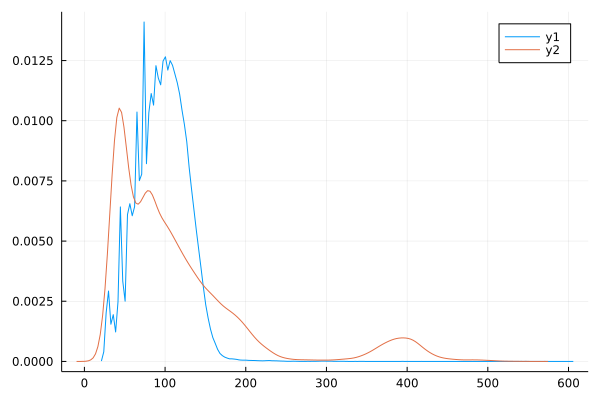

In [61]:
density(collect(skipmissing(filter(x->x.training>0.5,xold).QUAL_Vardict)))
density!(collect(skipmissing(filter(x->x.training<0.5,xold).QUAL_Vardict)))

In [62]:
# showtable(sample_key2[findall(x->x,[i==true for i in yold]),:]);

In [63]:
for j in 1:ncol(xold), i in 1:nrow(xold)
    if !ismissing(xold[i,j]) && (isnan(xold[i,j]) || isinf(xold[i,j]) )
        xold[i,j] = missing
    end
end

In [64]:
coldrop = [] # ["gt_AF_Vardict","AltFwd_Vardict","RefFwd_Vardict","AltRev_Vardict","RefRev_Vardict",
#     "gt_AD_ref_Vardict","gt_AD_alt_Vardict"]
for i in names(xold)
    if i == "col1" || i=="training"
        continue
    end
    if sum(ismissing.(xold[:,i])) / nrow(xold) > 0.6 
        push!(coldrop,i)
        println(i)
    end
    
    if length(unique(xold[:,i])) < 2 || occursin("Pindel",i) || occursin("Lofreq",i) || occursin("Mutect",i) # || occursin("ALT",i) || occursin("REF",i)
        push!(coldrop,i)
#         println(i)
    end 
end
unique!(coldrop);


gt_AD_alt_Pindel
gt_AD_ref_Pindel
gt_AF_Pindel
pon_pvalue_Pindel
total_greater_than_min_alt_count_Pindel
dust_score_Pindel
dust_score_3_Pindel
dust_score_5_Pindel
dust_score_10_Pindel
total_Pindel
total_greater_than_min_alt_count_Vardict
gt_AD_alt_Lofreq
total_greater_than_min_alt_count_Lofreq
GERMQ_Mutect
MPOS_Mutect
ROQ_Mutect
TLOD_Mutect
gt_AD_alt_Mutect
gt_AD_ref_Mutect
gt_AF_Mutect
RefFwd_Mutect
RefRev_Mutect
AltFwd_Mutect
AltRev_Mutect
pon_pvalue_Mutect
total_greater_than_min_alt_count_Mutect
dust_score_Mutect
dust_score_3_Mutect
dust_score_5_Mutect
dust_score_10_Mutect
total_Mutect
fwdbias_Mutect
revbias_Mutect
MBQ_Mutect_1
MBQ_Mutect_2
MFRL_Mutect_1
MFRL_Mutect_2
MMQ_Mutect_1
MMQ_Mutect_2


In [65]:
select!(xold, Not(coldrop));
println(sum([i==true for i in yold]))
# println(nrow(xold))
# dropmissing!(xold)
# println(nrow(xold))

println(size(yold))
println(length(sample_key2))
println()
yold = yold[xold.col1]
# println(xold[findall(x->x,[i==true for i in yold]),"col1"])
# println(xold[findall(x->!x,[i==true for i in yold]),"col1"])
sample_key2 = sample_key2[xold.col1]
select!(xold,Not("col1"));

println(size(xold))
println(size(yold))
println(length(sample_key2))
println(sum([i==true for i in yold]))

300
(1520209,)
1520209

(524042, 80)
(524042,)
524042
264


In [66]:
# istrain=0
# for i in 1:nrow(xold)
#     if sum(ismissing.(Vector(xold[i,:]))) > 0
# #         if xold[i,:training] > 0.5
# #             istrain += 1
# #         end
#         println(sample_key[i]," ",i)
#     end
# end
# println(istrain)

In [67]:
# showtable(xold[60:65,:])

In [68]:
# for col in names(xold)
#     println(col,"  ",1-sum(ismissing.(xold[:,col]))/nrow(xold) )
# end

In [69]:
# xold.sample_key=sample_key
# xold.real=[i==true for i in yold]
# filter(x->x.training>0.5 && x.real && (ismissing(x.MPOS_Mutect) || x.MPOS_Mutect < 30),xold)[:,["MPOS_Mutect","sample_key","real"]]

In [70]:
# namd=names(xsnv)[13] # 2,6,8,9,13
# namd="MBQ_Mutect_1"
# namd="MPOS_Mutect"
# xold.sample_key=sample_key
# xold.real=[i==true for i in yold]
# print(namd)
# histogram(collect(skipmissing(filter(x->x.training>0.5 && x.real,xold)[:,namd])),legend=true,label="TT",alpha=0.3,bins=10)
# histogram!(collect(skipmissing(filter(x->x.training<0.5 && x.real,xold)[:,namd])),label="BMT",alpha=0.3,bins=10)



In [71]:
# ysnv[[9, 12, 13, 14, 21, 24, 25, 26, 40, 41, 42, 44]];

In [72]:
# ysnv[[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 15,16]];

In [73]:
xsnv = copy(xold);
ysnv = copy(yold);



train2 = findall(x->x,[i>0.5 for i in xsnv.training])
test2 = findall(x->x,[i<0.5 for i in xsnv.training])

# train2 = [9, 12, 13, 14, 21, 24, 25, 26, 40, 41, 42, 44,
# 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 15,16
# ]

# test2=setdiff(collect(1:length(ysnv)),train2)

# train2, test2 = partition(eachindex(ysnv), 0.2, stratify=ysnv,  shuffle=true, rng=12344);

select!(xsnv,Not("training"));

println(length(train2))
println(length(test2))

502882
21160


In [74]:
transform_standardizer!(xsnv,fit_standardizer(xsnv[train2,:]));

In [75]:
# showtable(xsnv[1:10,:])

In [76]:
sum(ismissing.(Matrix(xsnv)))

418924

In [77]:
stmach = machine(MissingImputator(K=3),xsnv[train2,:]) 
@time sttran = fit!(stmach,verbosity=1)

┌ Info: Training Machine{MissingImputator,…}.
└ @ MLJBase /Users/alexpanchot/.julia/packages/MLJBase/HZmTU/src/machines.jl:403


156.515155 seconds (709.52 M allocations: 132.060 GiB, 22.54% gc time, 0.21% compilation time)


Machine{MissingImputator,…} trained 1 time; caches data
  args: 
    1:	Source @026 ⏎ `Table{Union{AbstractVector{Union{Missing, ScientificTypesBase.Continuous}}, AbstractVector{ScientificTypesBase.Continuous}}}`


In [78]:
tt = MLJ.transform(sttran,xsnv);
for i in 1:ncol(xsnv)
    xsnv[:,i] = tt[i]
end

In [79]:
disallowmissing!(xsnv);

In [80]:
sample_key = copy(sample_key2)
train = copy(train2)
test = copy(test2)
x = copy(xsnv);
y = copy(ysnv);

In [81]:
println(size(x[train,:])," ",sum([i==true for i in y[train]] ) )
println(size(x[test,:])," ",sum([i==true for i in y[test]] ) )
println(size(y[train]))
println(size(sample_key))

(502882, 79) 132
(21160, 79) 132
(502882,)
(524042,)


In [82]:
x,y,train,test,sample_key = sampler(x,y,train,test,sample_key,"under",0.0);
x,y,train,test,sample_key = sampler(x,y,train,test,sample_key,"over",0.01);

ratio: 0.0002625559423172551
number of new: 4896


In [83]:
y = coerce(copy(y),OrderedFactor);

In [84]:
println(size(x[train,:])," ",sum([i==true for i in y[train]] ) )
println(size(x[test,:])," ",sum([i==true for i in y[test]] ) )
println(size(y[train]))
println(size(sample_key))

(507778, 79) 5028
(21160, 79) 132
(507778,)
(528938,)


# MLJ Models

In [85]:
# select!(x,Not([]));

In [86]:

r = [
    range(EvoTreeClassifier(), :max_depth, lower=1,upper=7),
    range(EvoTreeClassifier(), :η, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :γ, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :λ, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :α, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :min_weight, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :nrounds, lower=1,upper=10),
    range(EvoTreeClassifier(), :nbins, lower=4, upper=128),
    
    
#     range(LogisticClassifier(), :lambda, lower=0.0,upper=1.0),
#     range(LogisticClassifier(), :gamma, lower=0.0,upper=1.0),
    
#     range(SVC(), :degree, lower=1,upper=4),
#     range(SVC(), :gamma, lower=0.0,upper=1.0),    
]

8-element Vector{MLJBase.NumericRange{T, MLJBase.Bounded, Symbol} where T}:
 NumericRange(1 ≤ max_depth ≤ 7; origin=4.0, unit=3.0)
 NumericRange(0.0 ≤ η ≤ 1.0; origin=0.5, unit=0.5)
 NumericRange(0.0 ≤ γ ≤ 1.0; origin=0.5, unit=0.5)
 NumericRange(0.0 ≤ λ ≤ 1.0; origin=0.5, unit=0.5)
 NumericRange(0.0 ≤ α ≤ 1.0; origin=0.5, unit=0.5)
 NumericRange(0.0 ≤ min_weight ≤ 1.0; origin=0.5, unit=0.5)
 NumericRange(1 ≤ nrounds ≤ 10; origin=5.5, unit=4.5)
 NumericRange(4 ≤ nbins ≤ 128; origin=66.0, unit=62.0)

In [87]:
self_tune = TunedModel(
#     model=LogisticClassifier(penalty=:l1),
#     model=SVC(),
    model=EvoTreeClassifier(),
    resampling=StratifiedCV(nfolds=5, rng=123),

    tuning=LatinHypercube(),  #     tuning=Grid(resolution=2), 
    range = r,
    n=5,
    operation=predict_mode, # use for probabalistic 
    measure = fnr,  # use for deterministic or with predict_mode for probab 
#     measure = brier_loss # use for probabalistic 
    acceleration=CPUThreads(),
)

machbest = machine(
    self_tune,
    x[train,:],y[train])
fit!(machbest,verbosity=1 )
# evaluate!(machbest,verbosity=2,resampling=StratifiedCV(nfolds=5, rng=123) )


┌ Info: Training Machine{ProbabilisticTunedModel{LatinHypercube,…},…}.
└ @ MLJBase /Users/alexpanchot/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
┌ Info: Attempting to evaluate 5 models.
└ @ MLJTuning /Users/alexpanchot/.julia/packages/MLJTuning/efiDR/src/tuned_models.jl:685
Evaluating over 5 metamodels: 100%[=========================] Time: 0:01:23


Machine{ProbabilisticTunedModel{LatinHypercube,…},…} trained 1 time; caches data
  args: 
    1:	Source @070 ⏎ `Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @470 ⏎ `AbstractVector{OrderedFactor{2}}`


In [88]:
yhat=MLJ.predict_mode(machbest, x[test,:]); # probab
# yhat=MLJ.predict(machbest, x[test,:]); # determ

In [89]:
ConfusionMatrix()(yhat,y[test])

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │    false    │    true     │
├─────────────┼─────────────┼─────────────┤
│    false    │    20081    │     103     │
├─────────────┼─────────────┼─────────────┤
│    true     │     947     │     29      │
└─────────────┴─────────────┴─────────────┘


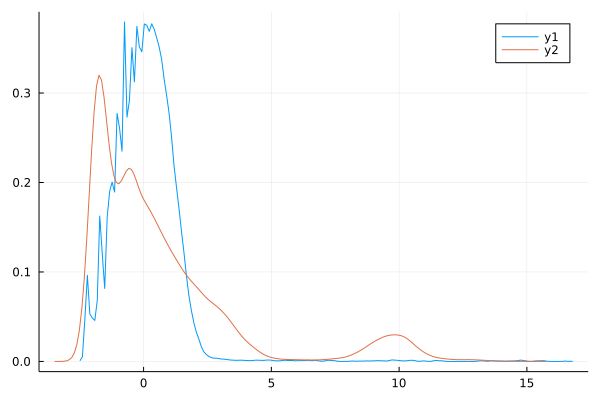

In [90]:
density(x.QUAL_Vardict[train])
density!(x.QUAL_Vardict[test])

In [171]:
report(machbest).best_report.feature_importances # Evo Tree
# fitted_params(machbest).best_fitted_params.coefs[sortperm([i[2] for i in fitted_params(machbest).best_fitted_params.coefs])]



71-element Vector{Pair{String, Float64}}:
                             "QUAL_Vardict" => 0.6196485634249338
                         "ODDRATIO_Vardict" => 0.18274894343717543
                       "pon_pvalue_Vardict" => 0.06468669617307501
                            "PMEAN_Vardict" => 0.02403881226892926
                            "HICNT_Vardict" => 0.021993458538717765
                           "SHIFT3_Vardict" => 0.013294313541671295
                               "SN_Vardict" => 0.012947031084409148
                                    "ALT_G" => 0.01280849157946636
                              "SBF_Vardict" => 0.011158461956390704
                               "NM_Vardict" => 0.0102931144643166
 "total_greater_than_min_alt_count_Vardict" => 0.006787369177769898
                             "HIAF_Vardict" => 0.006112595865205631
                                    "REF_G" => 0.006049629203272025
                                            ⋮
                              "SYMBO

In [57]:

# [println(i) for i in filter(x-> x.x1==false && x.x2==true ,aa).sample_key]
aa = DataFrame(x1=yhat,x2=y[test],sample_key=sample_key[test])
aafn=filter(x-> x.x1==false && x.x2==true ,aa)
aatp=filter(x-> x.x1==true && x.x2==true ,aa)

# CSV.write("bmtreals2.csv",leftjoin(CSV.read("bmtreals1.csv",DataFrame),
#         DataFrame(sample_key=aafn.sample_key, vardictFN = [1 for i in nrow(aafn)])
#         ,on=:sample_key))
# CSV.write("bmtreals2.csv",leftjoin(CSV.read("bmtreals2.csv",DataFrame),
#         DataFrame(sample_key=aatp.sample_key, vardictTP = [1 for i in nrow(aatp)])
#         ,on=:sample_key))



"bmtreals2.csv"

In [59]:
atemp=CSV.read("bmtreals2.csv",DataFrame)
coldrop = []
for i in names(atemp)
    
    if occursin("Pindel",i) || occursin("Lofreq",i) || occursin("Varscan",i) # || occursin("ALT",i) || occursin("REF",i)
        push!(coldrop,i)
#         println(i)
    end 
end
unique!(coldrop)
CSV.write("bmtreals3.csv",select(atemp,Not(coldrop)) )

"bmtreals3.csv"

# Bayes

In [41]:
xb = copy(x);
yb = [i==true for i in copy(y)];

In [42]:
#                             "gt_AF_Mutect" => 0.6343147138367103 #exp
#                       "FILTER_Mutect_PASS" => 0.1641440240799226 #bernoulli / binomial(n=1)
#                        "VARIANT_CLASS_SNV" => 0.056865397898697385 #bernoulli / binomial(n=1)
#                              "SYMBOL_TET2" => 0.044696231684754145#bernoulli / binomial(n=1)
#                              "MPOS_Mutect" => 0.0296128100961646 # Multinomial
#                                  "alt_len" => 0.02520787833141105 #exp
#                             "MBQ_Mutect_2" => 0.024020411336150856 # Multinomial
#                        "dust_score_Mutect" => 0.011542190026088157 # Multinomial
#                            "RefRev_Mutect" => 0.005482350181005947 # normal
#  "total_greater_than_min_alt_count_Mutect" => 0.004113992529094932 # Multinomial

"total_greater_than_min_alt_count_Mutect" => 0.004113992529094932

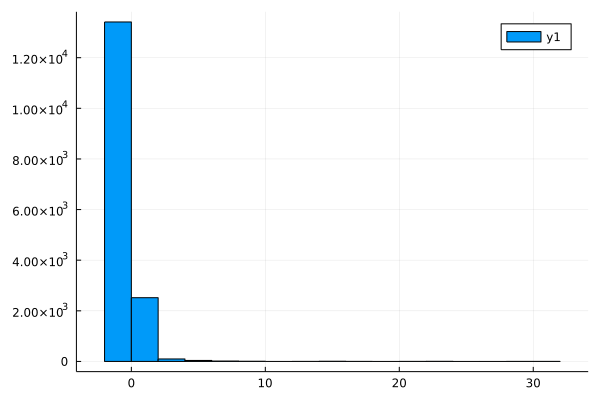

In [65]:
histogram(xb.ODDRATIO_Vardict,bins=20)

In [39]:
# ? Gamma()

In [47]:
@model function logistic_regression(x, y, n)
    intercept ~ Normal(0, 1)
    
#     p1 ~ Normal()
#     p2 ~ Beta()
#     p3 ~ Beta()
#     p4 ~ Beta()
#     p5 ~ Categorical(80)
#     p6 ~ Normal()
#     p7 ~ Categorical(5)
#     p8 ~ Normal()
#     p9 ~ Normal()
#     p10 ~ Categorical(25)
#     p11 ~ Categorical(5)
#     p12 ~ Categorical(3)
    
    p1 ~ Normal()
    p2 ~ Gamma()
    p3 ~ Gamma()
    p4 ~ Normal()
    p5 ~ Beta()
    
    for i = 1:n
#         v = logistic(intercept + sum(params .* Vector(x[i, :]) ) )
        v = logistic(intercept + p1 * x[i, 1] + p2 * x[i, 2] + p3 * x[i, 3] + p4 * x[i, 4] + p5 * x[i, 5]
        )
        y[i] ~ Bernoulli(v)
    end
end;

In [48]:
d = train #vcat(train[findall(x->x,yb[train])],train[1:1425])
inputvars = ["gt_AF_Vardict","ODDRATIO_Vardict","dust_score_Vardict","PMEAN_Vardict","pon_pvalue_Vardict"];

In [49]:
sum(.~ yb[d])

3204

In [50]:
sum(yb[d])

18

In [51]:
# findall(x->x,yb[train])

In [52]:
# train[1:385]

In [81]:

n = length(yb[d]) #["gt_AF_Vardict","gt_AF_Mutect","gt_AF_Lofreq","pon_pvalue_Vardict"]

# gmm_sampler = Gibbs(PG(100,:p5,:p7,:p10,:p11,:p12), HMC(0.05, 100, :intercept, :p1,:p2,:p3,:p4,:p6,:p8,:p9))

# Sample using HMC.
m = logistic_regression(xb[d,inputvars],yb[d], n)

chain = sample(m, HMC(0.005, 100), MCMCThreads(), 100, 6, drop_warmup=true, progress=true)
# chain = sample(m, gmm_sampler, MCMCThreads(), 100, 5, progress=true)
# chain = sample(m, NUTS(50,0.65), MCMCThreads(), 100, 2, progress=true)
# describe(chain)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /Users/alexpanchot/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /Users/alexpanchot/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /Users/alexpanchot/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
Sampling (6 threads): 100%|█████████████████████████████| Time: 0:00:59


Chains MCMC chain (100×15×6 Array{Float64, 3}):

Iterations        = 1:1:100
Number of chains  = 6
Samples per chain = 100
Wall duration     = 153.9 seconds
Compute duration  = 536.23 seconds
parameters        = intercept, p1, p2, p3, p4, p5
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

   intercept   -6.6187    4.4677     0.1824    0.4300   77.2268    1.0366      ⋯
          p1    2.1198    1.1819     0.0483    0.1142   76.2538    1.0345      ⋯
          p2    0.0727    0.0616     0.0025    0.0078   35.1384    1.1245      ⋯
          p3    0.2435    0.2387     0.0097    0.0353   13.6104    1.3619      ⋯
          p4    0.1434    0.2239     0.0091    0.0374   10.8239    1.5630      ⋯
          p5    0.0481   

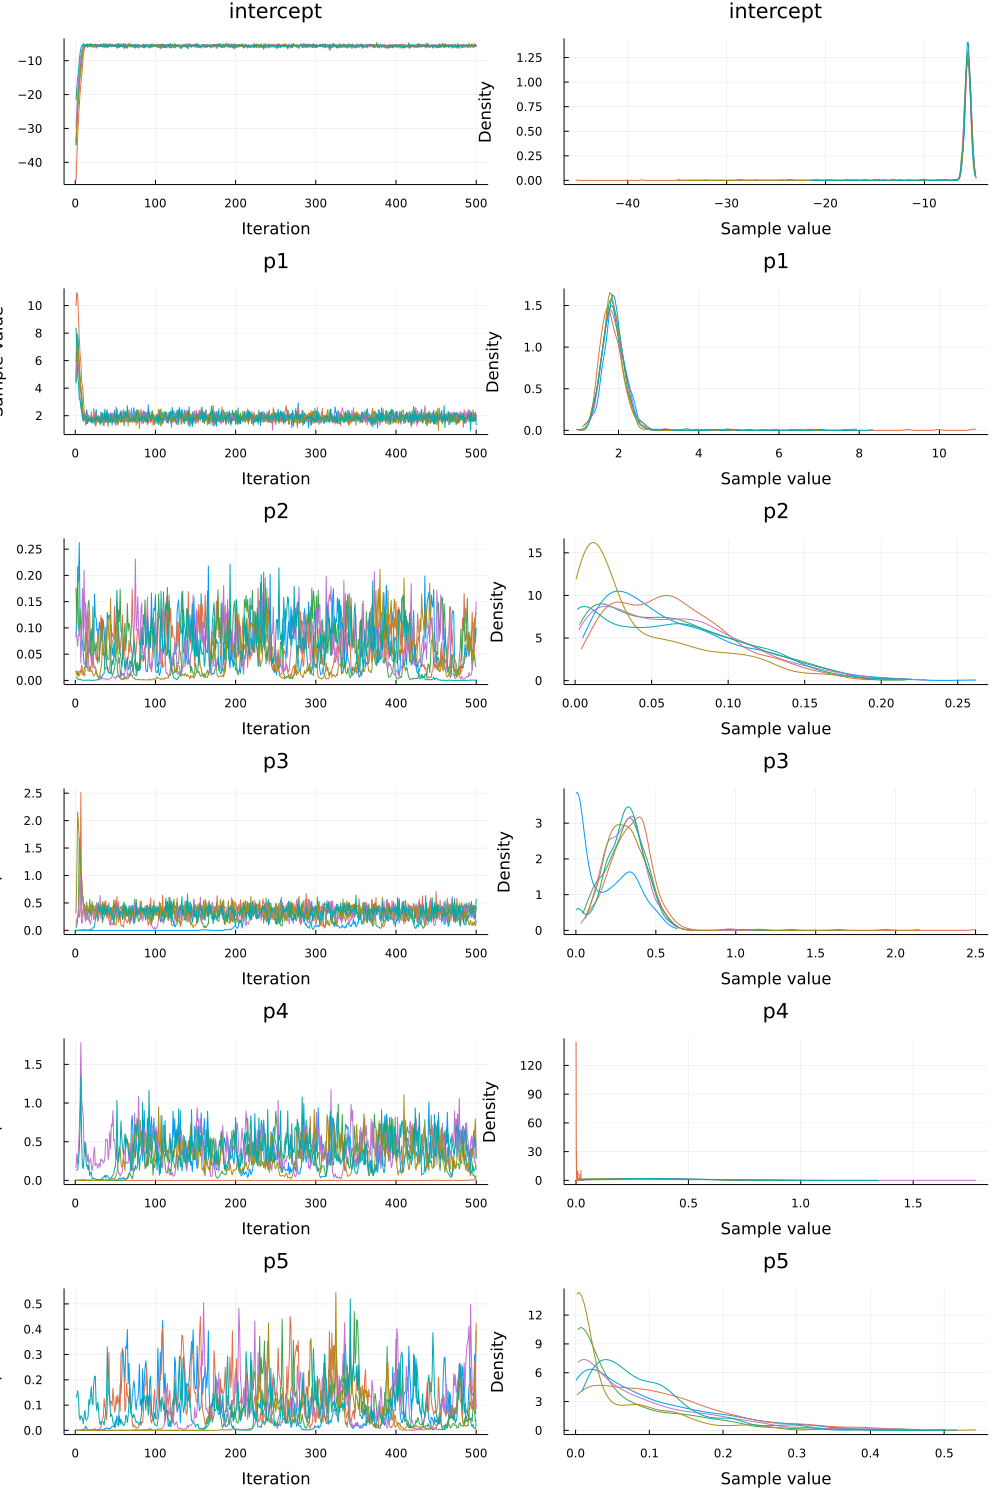

In [54]:
plot(chain)

In [67]:
function prediction_turing(x, chain)
    # Pull the means from each parameter's sampled values in the chain.
    intercept = mean(chain[:intercept])
    p1 = mean(chain[:p1])
    p2 = mean(chain[:p2])
    p3 = mean(chain[:p3])
    p4 = mean(chain[:p4])
    p5 = mean(chain[:p5])

    # Retrieve the number of rows.
    n = nrow(x)

    # Generate a vector to store our predictions.
    v = Vector{Float64}(undef, n)

    # Calculate the logistic function for each element in the test set.
    for i in 1:n
        v[i] = logistic(intercept + 
            p1*x[i, 1] + p2*x[i,2] + p3*x[i,3] + p4*x[i,4] + p5*x[i,5] 
        )
    end
    return v
end;

In [68]:
ypred = prediction_turing(xb[test,inputvars],chain);

In [78]:
yhat2 = [i>.1 ? true : false for i in ypred];

In [79]:
MLJ.ConfusionMatrix()(yhat2,yb[test])

┌ Warning: The classes are un-ordered,
│ using: negative='false' and positive='true'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /Users/alexpanchot/.julia/packages/MLJBase/HZmTU/src/measures/confusion_matrix.jl:112


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │    false    │    true     │
├─────────────┼─────────────┼─────────────┤
│    false    │    12800    │     29      │
├─────────────┼─────────────┼─────────────┤
│    true     │     17      │     43      │
└─────────────┴─────────────┴─────────────┘


In [73]:
# [print(i," ") for i in train]

In [304]:
asd=yhat2 .< yb[test];

In [305]:
sum(yb[test])

71

In [306]:
yb[test[asd]];

In [307]:
sample_key[test][asd]

34-element Vector{String}:
 "887041_1_1000 20:31022441 A>AG"
 "218281_1_100 2:25457243 G>A"
 "272341_1_1000 20:31022441 A>AG"
 "272341_1_5000 20:31022441 A>AG"
 "218281_1_10 2:25457243 G>A"
 "272341_1_10 20:31022441 A>AG"
 "736399_1_100 4:106190822 C>A"
 "218281_1_100 17:7578534 C>G"
 "887041_1_10 4:106196951 A>G"
 "809382_1_100 2:25536827 G>A"
 "887041_1_5000 20:31022441 A>AG"
 "272341_1_100 4:106155751 G>A"
 "218281_1_100 4:106193940 A>T"
 ⋮
 "887041_1_100 2:25467083 G>A"
 "761809_1_10 2:25457242 C>T"
 "809382_1_100 2:25467032 G>A"
 "809382_1_100 4:106157983 C>T"
 "218281_1_100 4:106180823 C>T"
 "761809_1_10 2:25536827 G>A"
 "887041_1_100 20:31022441 A>AG"
 "736399_1_100 17:58740521 G>T"
 "887041_1_100 4:106196951 A>G"
 "736399_1_100 4:106156187 C>T"
 "272341_1_100 4:106158216 G>A"
 "809382_1_100 4:106157569 A>T"

In [396]:
yb[train]

102-element Vector{Bool}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [398]:
sample_key[train][yb[train]]

34-element Vector{String}:
 "887041_1_100 20:31017746 CCAG>C"
 "D-1002 X:39923810 G>T"
 "218281_1_10 2:25457243 G>A"
 "761809_1_100 22:29085168 C>G"
 "218281_1_10 4:106193940 A>T"
 "887041_1_5000 20:30946591 CAGA>C"
 "272341_1_1000 20:31024787 T>C"
 "736399_1_5000 20:31022441 AG>A"
 "D-942 19:33792748 G>A"
 "736399_1_100 20:31022441 AG>A"
 "D-1002 X:39922132 A>C"
 "736399_1_10 4:106190822 C>A"
 "887041_1_1000 20:31023301 A>G"
 ⋮
 "D-1002 X:39909190 C>A"
 "D-1002 X:39922009 G>A"
 "736399_1_100 4:106196829 T>G"
 "809382_1_1000 20:31017746 CCAG>C"
 "887041_1_5000 17:74732995 C>G"
 "887041_1_100 4:106197574 GTC>G"
 "809382_1_5000 17:58678009 T>C"
 "D-1002 X:39916503 G>T"
 "887041_1_5000 2:198265526 A>G"
 "D-942 4:106157663 C>T"
 "218281_1_100 4:106180823 C>T"
 "809382_1_100 2:25464444 A>G"